In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt',quiet = True)
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
from collections import Counter
nltk.download('stopwords',quiet = True)

True

In [3]:
PATH = '/content/gdrive/MyDrive/6120_group/final_proj/'

In [4]:
movie_details_df = pd.read_json(PATH + 'IMDB_movie_details.json', lines=True)
movie_review_df = pd.read_json(PATH + 'IMDB_reviews.json', lines=True)

In [5]:
book_review_df = pd.read_json(PATH + 'goodreads_reviews_spoiler.json', lines=True, nrows=100000)

In [6]:
movie_details_df.info()
movie_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating         

In [ ]:
book_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           100000 non-null  object        
 1   timestamp         100000 non-null  datetime64[ns]
 2   review_sentences  100000 non-null  object        
 3   rating            100000 non-null  int64         
 4   has_spoiler       100000 non-null  bool          
 5   book_id           100000 non-null  int64         
 6   review_id         100000 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 4.7+ MB


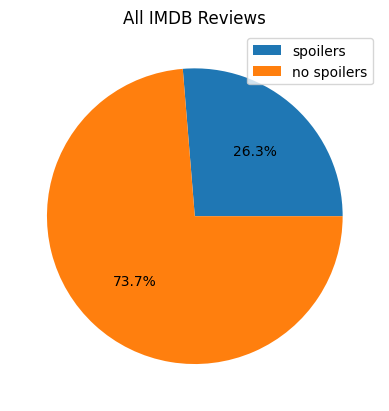

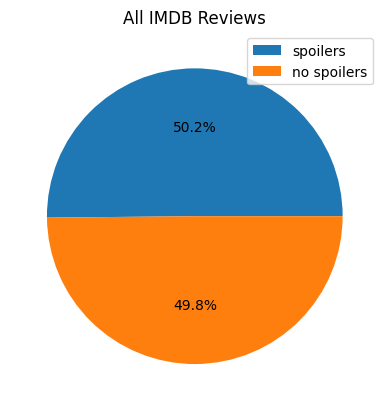

<ipython-input-7-34c7d4d1abcd>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movie_review_df = spoilers.append(no_spoilers, ignore_index=True)


In [ ]:
# IMDB dataset statistics

spoilers = movie_review_df[movie_review_df['is_spoiler'] == 1]
no_spoilers = movie_review_df[movie_review_df['is_spoiler'] == 0]

# plot dataset
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('All IMDB Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()


# balance dataset (remove neg labels)

# get indices of reviews with no spoilers
no_spoilers_indices = movie_review_df.index[movie_review_df['is_spoiler'] == 0]
removed_indices = no_spoilers_indices[:150000]
no_spoilers = movie_review_df.iloc[removed_indices]

# plot dataset with neg labels removed
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('All IMDB Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()

# get new dataframe
movie_review_df = spoilers.append(no_spoilers, ignore_index=True)

In [ ]:
# IMDB dataset preprocessing

movie_review_data = []

for review in tqdm(movie_review_df['review_text'].values):
    # tokenize review text
    tokens = word_tokenize(review)
    # lowercase
    tokens = [token.lower() for token in tokens]
    movie_review_data.append(tokens)

100%|██████████| 300924/300924 [10:26<00:00, 480.41it/s]


In [ ]:
#Preprocessing the data
stop_words = set(nltk.corpus.stopwords.words('english'))
processed_texts = [[word for word in document.lower().split() if word not in stop_words] for document in tqdm(movie_review_df['review_text'].values)]

100%|██████████| 300924/300924 [00:18<00:00, 16416.30it/s]


In [ ]:
labels = [1 if x else 0 for x in tqdm(movie_review_df['is_spoiler'])] #creating labels column

100%|██████████| 300924/300924 [00:00<00:00, 2610711.47it/s]


In [ ]:
#Training word embeddings using for Word2Vec and Fasttext

from gensim.models import Word2Vec, FastText

w2c_model = Word2Vec(processed_texts,sg = 0)
fasttext_model = FastText(sentences=processed_texts, vector_size=100, window=5, min_count=5, workers=4)


In [ ]:
#Saving the models

w2c_model.save(PATH+"Word2Vec_imdb/w2v_imdb.model")
fasttext_model.save(PATH+"Word2Vec_imdb/ft_imdb.model")

In [ ]:
#Import the loaded model

w2c_model = Word2Vec.load(PATH+"Word2Vec_imdb/w2v_imdb.model")
fasttext_model = FastText.load(PATH+"Word2Vec_imdb/ft_imdb.model")

# Use Word2Vec embeddings to represent each text document
unknown_token = np.zeros(w2c_model.vector_size)  # Vector representation for unknown words
document_vectors = np.array([np.mean([w2c_model.wv[word] if word in w2c_model.wv \
                                      else unknown_token for word in doc], axis=0)\
                                      for doc in processed_texts])

# # Use Fasttext embeddings to represent each text document
document_vectors_ft = np.array([np.mean([fasttext_model.wv[word] \
                                         for word in doc], axis=0)\
                                         for doc in tqdm(processed_texts)])



100%|██████████| 300924/300924 [04:06<00:00, 1220.46it/s]


In [ ]:
# document_vectors_ft
# sl_ft = []
# for x in tqdm(movie_review_df['review_text']):
 
#   if len(nltk.word_tokenize(x)) > 350:
#     sl_ft.append(1)
#   else:
#     sl_ft.append(0)

100%|██████████| 300924/300924 [10:24<00:00, 482.24it/s]


In [ ]:
# IMDB dataset for Logistic Regression

# feature list:
# number of 'spoiler' words
# log number of words in review 
# ...
# ...
def featurize(review_text):
    num_spoiler = 0
    for token in review_text:
      if token == 'spoiler':
            num_spoiler += 1

    return [num_spoiler, np.log(len(review_text))]

samples = np.array([featurize(review) for review in movie_review_data])
labels = np.array(movie_review_df['is_spoiler'].values, dtype=np.int64)

print(samples.shape)
print(labels.shape)

(300924, 2)
(300924,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=10)

model = LogisticRegression()
model.fit(X_train, y_train)

print(f'Accuracy on Train Data: {model.score(X_train, y_train)}')
print(f'Accuracy on Test Data: {model.score(X_test, y_test)}')

Accuracy on Train Data: 0.6084847075048081
Accuracy on Test Data: 0.6115809587106422


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(classification_report(y_test,y_pred_test))    #Report for test set

              precision    recall  f1-score   support

           0       0.60      0.66      0.63     29985
           1       0.63      0.56      0.59     30200

    accuracy                           0.61     60185
   macro avg       0.61      0.61      0.61     60185
weighted avg       0.61      0.61      0.61     60185



In [ ]:
print(classification_report(y_train, y_pred_train))   #Report for train set

              precision    recall  f1-score   support

           0       0.60      0.66      0.63    120015
           1       0.62      0.56      0.59    120724

    accuracy                           0.61    240739
   macro avg       0.61      0.61      0.61    240739
weighted avg       0.61      0.61      0.61    240739



In [ ]:
cm_test = confusion_matrix(y_test,y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test

array([[19862, 10123],
       [13254, 16946]])

Text(0.5, 1.0, 'Confusion Matrix for Test set')

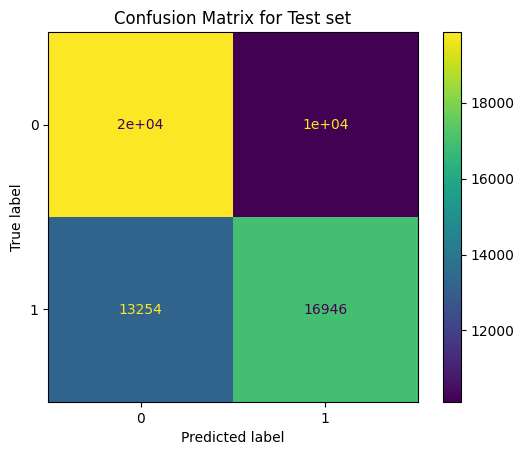

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, display_labels = model.classes_)
plt.title("Confusion Matrix for Test set")

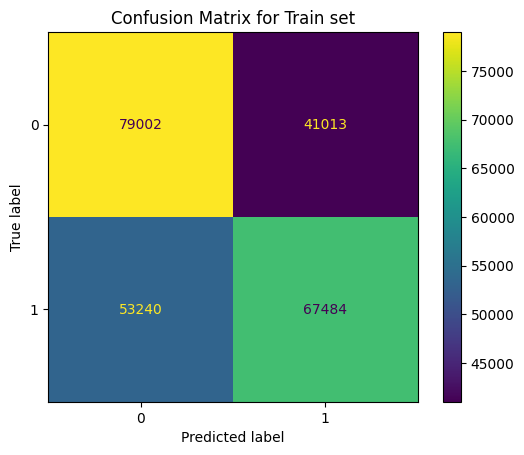

In [ ]:
ConfusionMatrixDisplay(cm_train, display_labels = model.classes_).plot()
plt.title("Confusion Matrix for Train set")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [ ]:
#HyperParameter Optimization

clf = GridSearchCV(model,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=5)                     # number of folds

clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [ ]:
# Print the best parameters for Logistic Regression model

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.6122273575515103


In [ ]:
#Logistic Regression using the best model parameters

tuned_LR = LogisticRegression(C= 0.001, penalty = 'l2', solver = 'liblinear')
tuned_LR.fit(X_train, y_train)
y_tuned_test = tuned_LR.predict(X_test)

print(classification_report(y_test, y_tuned_test))  # Report for test set using tuned model

              precision    recall  f1-score   support

           0       0.61      0.63      0.62     29985
           1       0.62      0.60      0.61     30200

    accuracy                           0.61     60185
   macro avg       0.61      0.61      0.61     60185
weighted avg       0.61      0.61      0.61     60185



Text(0.5, 1.0, 'Confusion Matrix for test set tuned')

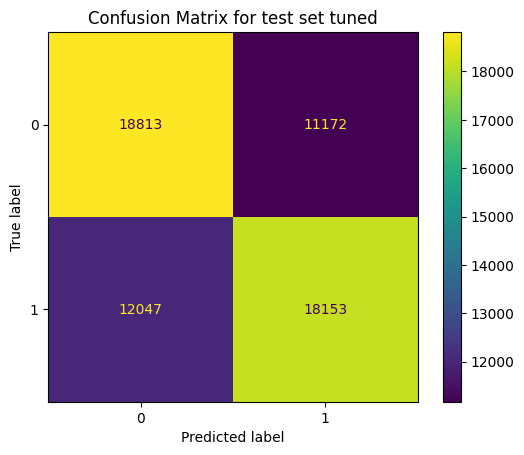

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_tuned_test, display_labels = tuned_LR.classes_)
plt.title("Confusion Matrix for test set tuned")

In [ ]:
tuned_LR.coef_

array([[0.85275446, 0.33855508]])

In [ ]:
model.coef_

array([[1.51527518, 0.79425269]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(document_vectors, labels, test_size=0.2, random_state=42)

tuned_LR_w2v = LogisticRegression(C= 0.001, penalty = 'l2', solver = 'liblinear')

tuned_LR_w2v.fit(X_train, y_train)
y_tuned_w2v_test = tuned_LR_w2v.predict(X_test)

print(classification_report(y_test, y_tuned_w2v_test))  # Report for test set using tuned model

              precision    recall  f1-score   support

           0       0.69      0.67      0.68     30031
           1       0.68      0.69      0.69     30154

    accuracy                           0.68     60185
   macro avg       0.68      0.68      0.68     60185
weighted avg       0.68      0.68      0.68     60185



In [ ]:
print(accuracy_score(y_test, y_tuned_w2v_test))

0.6837417961286034


Text(0.5, 1.0, 'Confusion Matrix for test set word2vec')

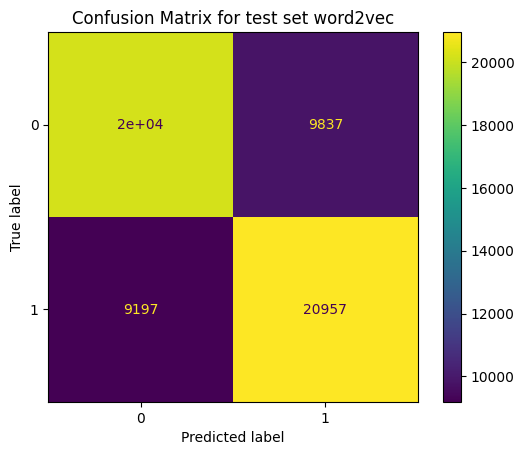

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_tuned_w2v_test, display_labels = tuned_LR_w2v.classes_)
plt.title("Confusion Matrix for test set word2vec")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(document_vectors_ft, labels, test_size=0.2, random_state=42)

tuned_LR_ft = LogisticRegression(C= 0.001, penalty = 'l2', solver = 'liblinear')

tuned_LR_ft.fit(X_train, y_train)
y_tuned_ft_test = tuned_LR_ft.predict(X_test)

print(classification_report(y_test, y_tuned_ft_test))  # Report for test set using tuned model

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     30031
           1       0.68      0.69      0.69     30154

    accuracy                           0.68     60185
   macro avg       0.68      0.68      0.68     60185
weighted avg       0.68      0.68      0.68     60185



In [ ]:
# IMDB dataset statistics

spoilers = movie_review_df[movie_review_df['is_spoiler'] == 1]
no_spoilers = movie_review_df[movie_review_df['is_spoiler'] == 0]

# plot dataset
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('All IMDB Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()


# balance dataset (remove neg labels)

# get indices of reviews with no spoilers
no_spoilers_indices = movie_review_df.index[movie_review_df['is_spoiler'] == 0]
removed_indices = no_spoilers_indices[:150000]
no_spoilers = movie_review_df.iloc[removed_indices]

# plot dataset with neg labels removed
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('All IMDB Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()

# get new dataframe
movie_review_df = spoilers.append(no_spoilers, ignore_index=True)

In [ ]:
book_review_df.i

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           100000 non-null  object        
 1   timestamp         100000 non-null  datetime64[ns]
 2   review_sentences  100000 non-null  object        
 3   rating            100000 non-null  int64         
 4   has_spoiler       100000 non-null  bool          
 5   book_id           100000 non-null  int64         
 6   review_id         100000 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 4.7+ MB


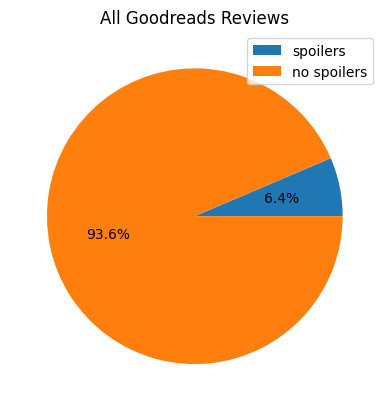

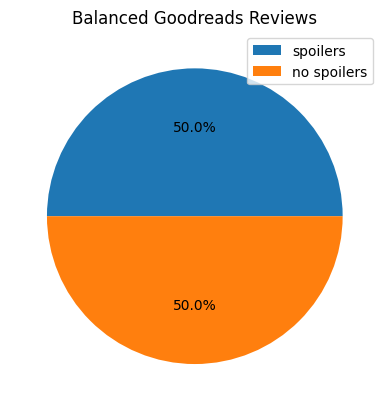

<ipython-input-7-96ce26f78b46>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  book_review_df = spoilers.append(no_spoilers, ignore_index=True)


In [7]:
# Goodreads dataset statistics

spoilers = book_review_df[book_review_df['has_spoiler'] == True]
no_spoilers = book_review_df[book_review_df['has_spoiler'] == False]
len(no_spoilers)
# plot dataset
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('All Goodreads Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()

# balance dataset (remove neg labels)

# get indices of reviews with no spoilers
no_spoilers_indices = book_review_df.index[book_review_df['has_spoiler'] == True]
removed_indices = no_spoilers_indices[:150000]
no_spoilers = book_review_df.iloc[removed_indices]

# plot dataset with neg labels removed
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('Balanced Goodreads Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()

# get new dataframe
book_review_df = spoilers.append(no_spoilers, ignore_index=True)

In [ ]:
def make_ngrams(tokens: list, n: int, padding=False) -> list:
    """
    Creates n-grams for the given token sequence.
    Args:
      tokens (list): a list of tokens as strings
      n (int): the length of n-grams to create
      padding (optional bool): whether to add end and beginning padding

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    n = 2
    [(token1, token2), (token2, token3), ....]
    """    
    if padding:
      tokens.insert(0,"<s>")
      tokens.append("</s>")
      
    ngrams = []
    for i in range(n):
      ngrams.append(tokens[i:])
    
    return list(zip(*ngrams))

In [ ]:
# Bookreads dataset for Logistic Regression

# feature list:
# number of 'spoiler' words
# log number of words in review 
# ...
# ...
def featurize(review_text):
    num_spoiler = 0
    for token in review_text:
      if token == 'spoiler':
            num_spoiler += 1

    return [num_spoiler, np.log(len(review_text))]

samples = []
labels = []
for review in tqdm(book_review_df['review_sentences'].values):
    # get samples and labels
    review_matrix = np.array(review)
    sents = review_matrix[:,-1]
    sent_labels = review_matrix[:,0]
    
    labels += list(sent_labels)
    samples += [featurize(sents) for sent in list(sents)]

samples = np.array(samples)
labels = np.array(labels, dtype=np.int64)

print(samples.shape)
print(labels.shape)

100%|██████████| 12318/12318 [00:10<00:00, 1187.95it/s]

(226641, 2)
(226641,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=5)

model = LogisticRegression()
model.fit(X_train, y_train)

print(f'Accuracy on Train Data: {model.score(X_train, y_train)}')
print(f'Accuracy on Test Data: {model.score(X_test, y_test)}')

Accuracy on Train Data: 0.8290460642428521
Accuracy on Test Data: 0.8325575238809592


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(classification_report(y_test,y_pred_test))    #Report for test set

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     37739
           1       0.00      0.00      0.00      7590

    accuracy                           0.83     45329
   macro avg       0.42      0.50      0.45     45329
weighted avg       0.69      0.83      0.76     45329



In [ ]:
print(classification_report(y_train, y_pred_train, zero_division=1))   #Report for train set

              precision    recall  f1-score   support

           0       0.73      1.00      0.85    170075
           1       1.00      0.00      0.00     61846

    accuracy                           0.73    231921
   macro avg       0.87      0.50      0.42    231921
weighted avg       0.80      0.73      0.62    231921

